In [21]:
import pandas as pd
import json
import os
import tensorflow as tf

In [13]:
labelPath = "C:/Users/RA_CT/Desktop/Tek_Juice/cldModel/cassava-leaf-disease-classification/label_num_to_disease_map.json"

In [14]:
trainLabel = "C:/Users/RA_CT/Desktop/Tek_Juice/cldModel/cassava-leaf-disease-classification/train.csv"

In [17]:
with open(labelPath, "r") as f:
    labeMap =  json.load(f)
print(labeMap)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [ ]:
df = pd.read_csv(trainLabel)
print(df.head())

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3


In [18]:
imagePath = "C:/Users/RA_CT/Desktop/Tek_Juice/cldModel/cassava-leaf-disease-classification/train_images"

In [27]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

image_path =   [imagePath + "/" + img for img in df ['image_id']]
labels = df['label'].values

# Convert to TF Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

# Load and preprocess images
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = img / 255.0
    return img, label

dataset = dataset.map(process_image)
dataset = dataset.shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Label (number): 3
Predicted Disease Name: Cassava Mosaic Disease (CMD)


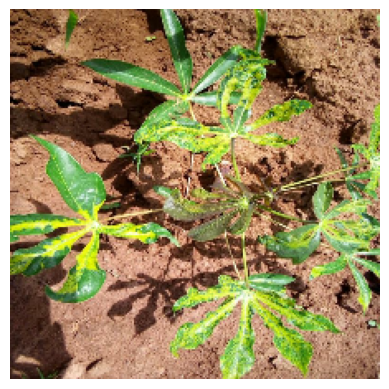

In [ ]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for images, labels in dataset.take(1):
    # Take the first image from the batch
    img = images[0].numpy()        # Convert tensor to NumPy array
    label = labels[0].numpy()      # Convert label tensor to scalar

    print("Label (number):", label)

    # using the label map dictionary
    disease_name = labeMap[str(label)]
    print("Predicted Disease Name:", disease_name)

    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [34]:
# split train and validation dataset 
dataset_size = len(image_path)
train_size = int(0.9 *dataset_size)
val_size = dataset_size - train_size

print(f"Data set size {dataset_size}")
print(f"Train Data set size {train_size}")
print(f"Val Data set size {val_size}")

Data set size 21397
Train Data set size 19257
Val Data set size 2140


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Preparing the model 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape= (224, 224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accurancy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)